In [1]:
%matplotlib inline

from shared_content import *

In [2]:
# Do you want to write figures to png files? Careful, it will overwrite!
write_figures = False
figdir = 'Figures/'

In [3]:
filedir = 'anafiles/'
#'SingleMuonRecoTrack'
#'MCBNBSelectedRecoTrack'
#'DataBNBSelectedRecoTrack'
#'MCBNBRecoTrack'
#'MCBNBMCTrack'
#'SingleMuonMCTrack'
#'MCBNBMCTrackExiting'
anatype = 'MCBNBMCTrackExiting' 

seglen = 10
myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_nonrelfix.root' %( anatype, seglen )
print myfile

MCSBiasStudy_MCBNBMCTrackExiting_anaout_10cmseg_2res_bothscatters_nonrelfix.root


In [4]:
df, segdf = get_dfs(filedir + myfile)
print len(segdf)
print df.columns.values

1043611
['full_length' 'full_integrated_length' 'full_range_energy'
 'full_range_momentum' 'full_integrated_range_energy'
 'full_integrated_range_momentum' 'full_MCS_energy' 'full_MCS_momentum'
 'true_E' 'true_momentum' 'theta' 'angle_wrt_x' 'angle_wrt_y' 'run'
 'subrun' 'eventid' 'full_MCS_momentum_inverse'
 'full_range_momentum_inverse' 'true_momentum_inverse' 'MCT_PDG'
 'MCT_origin']


In [5]:
# Basic plot of muon energy and angle spectra ala Bruce's request
if anatype == 'MCBNBMCTrack':
    # Energy spectra
    myx = df['true_E'].values
    plt.figure(figsize=(10,6))
    plt.hist(myx,bins=np.linspace(0,2.2,100),alpha=0.5)
    plt.grid(True,'both')
    plt.title('True Muons Passing Selection Cuts',fontsize=16)
    plt.xlabel('True Total Energy [GeV]',fontsize=14)
    plt.ylabel('Events')
    plt.yscale('log')
    if write_figures == True:
        plotname = 'MCBNBMCTrack_EnergySpectrum.png'
        print "Saving figure %s"%plotname
        plt.tight_layout()
        plt.savefig(figdir + plotname)
    
    # Angle spectra
    myx = df['theta'].values
    plt.figure(figsize=(10,6))
    plt.hist(myx,bins=np.linspace(0,3.14159,100),alpha=0.5)
    plt.grid(True,'both')
    plt.title('True Muons Passing Selection Cuts',fontsize=16)
    plt.xlabel('True Theta Angle w.r.t. Beam [rad]',fontsize=14)
    plt.ylabel('Events')
    if write_figures == True:
        plotname = 'MCBNBMCTrack_AngleSpectrum.png'
        print "Saving figure %s"%plotname
        plt.tight_layout()
        plt.savefig(figdir + plotname)

In [6]:
def basic_comparison_fig(xvar, yvar, plotname =None, extraquery = None, addtext = None, nbins=50, binmin = 0, binmax = 2):
    plt.figure(figsize=(10,6)) 
    myquery = 'true_E < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery
    myx = df.query(myquery)[xvar].values
    myy = df.query(myquery)[yvar].values
    blah = plt.hist2d(myx,myy,bins=((np.linspace(binmin,binmax,nbins),np.linspace(binmin,binmax,nbins))),cmin=1)
    blah = plt.colorbar()
    blah = plt.grid(True)
    blha = plt.xlabel('%s'%titles[xvar],fontsize=16)
    blha = plt.ylabel('%s'%titles[yvar],fontsize=16)
    blha = plt.title('%s'%titles[anatype],fontsize=16)
    blha.set_y(1.04)
    blah = plt.plot([0,100],[0,100],'g--',linewidth=3)
    
    if addtext is not None:
        plt.text(plt.xlim()[1]*0.55, plt.ylim()[1]*0.1, addtext, fontsize=20)
        
    if write_figures:
        if plotname is not None: 
            print "Saving figure %s"%plotname
            plt.tight_layout()
            plt.savefig(figdir + plotname)
        else: print "YOU WANTED TO SAVE A PLOT BUT DIDN'T GIVE A PLOT NAME!"

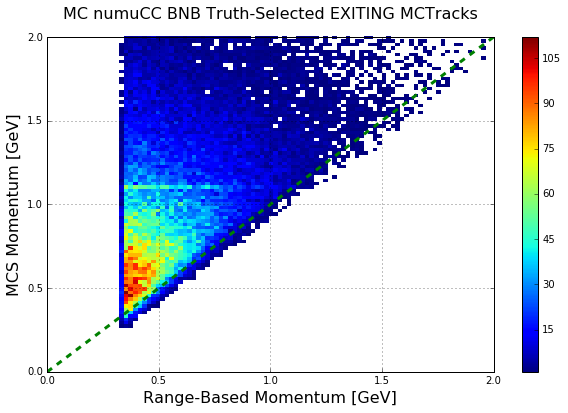

In [7]:
# MCS momentum vs range momentum for all samples
basic_comparison_fig(xvar='full_range_momentum',yvar='full_MCS_momentum',
                         plotname='MCS_range_comparison_%s.png'%anatype,
                        nbins = 100)

In [8]:
# Range energy vs True Energy for single muon MCTrack analysis only
#if anatype == 'SingleMuonMCTrack':
if anatype == 'MCBNBMCTrack':
    basic_comparison_fig(xvar='true_E',yvar='full_range_energy',
                         plotname='true_range_comparison_MCTracks.png',
                        nbins=100)


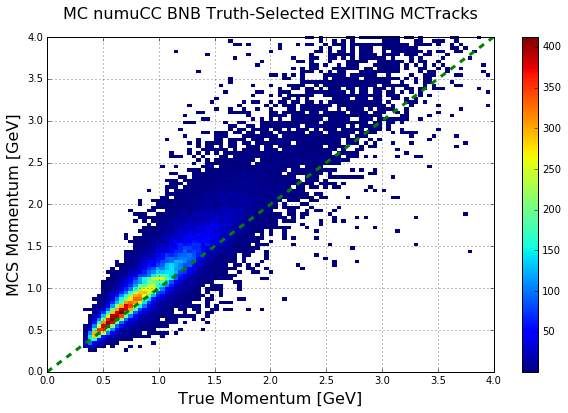

In [9]:
# MCS momentum vs True momentum for EXITING MCTRACK ANALYSIS ONLY
if anatype == 'MCBNBMCTrackExiting':
    basic_comparison_fig(xvar='true_momentum',yvar='full_MCS_momentum',
                         plotname='true_MCS_comparison_ExitingMCTracks.png',
                        nbins=100,binmin=0,binmax=4)


In [10]:
#Breakdown of proton, pion MIDs and true muon IDs
if anatype == 'MCBNBSelectedRecoTrack':

    for (pdg,name) in [ (211,'Pion MIDs'), (13,'True Muons'), (2212, 'Proton MIDs')]:
        
        #Testing this way
        extraquery = 'MCT_PDG == %d or MCT_PDG == -%d'%(pdg,pdg)
        basic_comparison_fig(xvar='full_range_momentum',yvar='full_MCS_momentum',
                         plotname='MCS_range_momentum_MCBNBSelectedRecoTrack_%d.png' % pdg,
                            extraquery = extraquery,
                            addtext = name)
    # Pie chart!

    plt.figure(figsize=(10,6))
    
    sizes = [ len(df.query('MCT_PDG == %d or MCT_PDG == -%d'%(13,13))),
              len(df.query('MCT_PDG == %d or MCT_PDG == -%d'%(211,211))),
              len(df.query('MCT_PDG == %d or MCT_PDG == -%d'%(2212,2212))) ]
    total = float(np.sum(sizes))
    labels = ['Muon (%0.1f%%)' % (100.*(sizes[0]/total)), 
              'Pion (%0.1f%%)' % (100.*(sizes[1]/total)), 
              'Proton (%0.1f%%)' % (100.*(sizes[2]/total))]
    colors = ['yellowgreen', 'lightskyblue', 'lightcoral']
 
    explode = (0.1, 0, 0)  # explode muon slice
 
    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            shadow=True, startangle=140)
     
    plt.axis('equal')
    if write_figures:
        print "Saving figure",'MCBNBSelectedRecoTrack_MID_piechart.png'
        plt.savefig(figdir+'MCBNBSelectedRecoTrack_MID_piechart.png')
    

In [11]:
print len(df)

53044


In [12]:
#Read in handscan info if working with data
if anatype == 'DataBNBSelectedRecoTrack':
    filedir = 'handscan_results/'
    myfile = 'handscan_results_kaleko.csv'
    
    hsdf = pd.read_csv(filedir + myfile,index_col=False)
       
    #Column names with spaces are hard to deal with, this is easy
    cols = hsdf.columns
    cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
    hsdf.columns = cols
    
    #If no optional comments were typed in it shows up as NaN
    #Let's just make a column of "optional comments present" (boolean)
    
    hsdf['comments_present'] = hsdf['optional_comments'].notnull()
    
    #Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
    hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0
    
    #maybe bad is either definitely_bad, or if comments are present (more conservative)
    hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']
    
    print "total length of hsdf is",len(hsdf)
    print "number of definitely bad is",len(hsdf.query('definitely_bad'))
    print "number of maybe bad is",len(hsdf.query('maybe_bad'))
    
    #let's rename run, subrun, eventid columns to match the MCS df
    #for now just make a new column because it's easier
    hsdf['run'] = hsdf['Run']
    hsdf['subrun'] = hsdf['Subrun']
    hsdf['eventid'] = hsdf['Event_ID']
    
    df = df.merge(hsdf, on=['run','subrun','eventid'])

    segdf = segdf.merge(hsdf, on=['run','subrun','eventid'])

In [13]:
#Breakdown of events that were handscanned as good, and those handscanned as bad
if anatype == 'DataBNBSelectedRecoTrack':

    extraquery = 'not maybe_bad'
    basic_comparison_fig(xvar='full_range_momentum',yvar='full_MCS_momentum',
                         plotname='MCS_range_momentum_DataRecoTracks_goodhandscan.png',
                            extraquery = extraquery,
                        addtext = 'Good Scan Sample')
    
    extraquery = 'maybe_bad'
    basic_comparison_fig(xvar='full_range_momentum',yvar='full_MCS_momentum',
                         plotname='MCS_range_momentum_DataRecoTracks_badhandscan.png',
                            extraquery = extraquery,
                        addtext = 'Bad Scan Sample')

In [14]:
#def highlandE(rms):
#    loverX = float(seglen)/14.
#    return np.sqrt((13.6*13.6*loverX*np.square((1+0.038*np.log(loverX))))/np.square(rms))

In [15]:
def deflection_plot(binmin,binmax,nbins,extraquery=None,plotname=None, addtext=None, figname = None, customtitle = None):
    
    fig = plt.figure(figsize=(10,6))
    
    poop = plt.grid(True)
    
    myquery = 'run < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery
    print myquery
    mybins = np.linspace(binmin,binmax,nbins)
    
    myvar1 = 'dthetayoverpredictedRMS_fromMCS'
    myvar2 = 'dthetaxoverpredictedRMS_fromMCS'

    myvals = np.append(
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar1,binmin,myvar1,binmax))[myvar1].values,
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar2,binmin,myvar2,binmax))[myvar2].values
    )
        
    mystd = np.std(myvals)
    mymean = np.mean(myvals)

    datahist = plt.hist(myvals,bins=mybins,normed=True,
                             alpha=0.5,label='$\Delta\\theta/RMS$ Values')#,
                            #weights = myweights)
   
    datahist_nonorm = np.histogram(myvals,bins=mybins,normed=False)
    
    binvals = datahist[0]
    bincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
    # Fit a normal distribution
    gmod = Model(gaussian)
    #initial random guesses of 1, 1, 2
    result = gmod.fit(binvals, x=bincenters, amp=1, cen=1, wid=2)

    #print(result.fit_report())
    #print help(result)
    #plt.plot(bincenters, binvals,         'bo')
    #plt.plot(bincenters, result.init_fit, 'k--')
    print result.params
    plt.plot(bincenters, result.best_fit, 'g-',\
             label='Gaussian Fit: $\sigma$ = %0.2f' % result.params['wid'],\
            linewidth=4)
  
    #data_mu, data_std = norm.fit(myvals)
    
    #myhighland = highlandE(data_std)

    # Plot the PDF.
    #x = np.linspace(binmin,binmax,100)
    #p = norm.pdf(x, data_mu, data_std)
    #plt.plot(x, p, 'g', linewidth=4,label='Gaussian Fit to Data')
    
    
    plt.title('%s'%titles[anatype],fontsize=14)
   
    if customtitle is not None:
        plt.title(customtitle,fontsize=14)
        
    plt.xlabel('Delta Theta / RMS',fontsize=16)
    blah = plt.legend(loc='best')
    leg = plt.legend(loc=2)
    
    if addtext is not None:
        plt.text(plt.xlim()[1]*0.25, plt.ylim()[1]*0.85, addtext, fontsize=20)
        
    if write_figures:
        fullfigname = figdir + 'Highland_validation_%s.png' % anatype
        if figname is not None:
            fullfigname = figdir + figname
            
        print "\n\n WRITING FIGURE %s! \n\n"%fullfigname
        plt.tight_layout()
        if plotname is not None: plt.savefig(figdir + plotname)
        else: plt.savefig(fullfigname)

run < 99999999
Parameters([('amp', <Parameter 'amp', value=0.97734855384862773 +/- 0.00761, bounds=[-inf:inf]>), ('cen', <Parameter 'cen', value=0.0010168331972675961 +/- 0.00858, bounds=[-inf:inf]>), ('wid', <Parameter 'wid', value=0.9536207143696368 +/- 0.00858, bounds=[-inf:inf]>)])


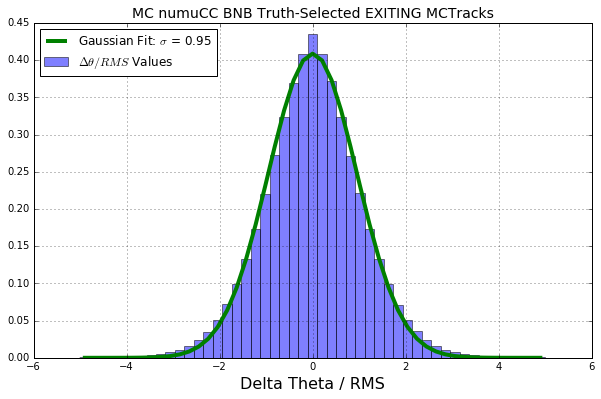

In [16]:
# For MCBNBSelectedRecoTrack only make highland validation plot for the true muons
myextraquery = None
if anatype == 'MCBNBSelectedRecoTrack':
    myextraquery = 'MCT_PDG == 13 or MCT_PDG == -13'
# For real data events, only make plot for those events handscanned as "good"
if anatype == 'DataBNBSelectedRecoTrack':
    myextraquery = 'not maybe_bad'
    
dummy = deflection_plot(-5,5,50,extraquery=myextraquery)

if anatype == 'DataBNBSelectedRecoTrack':
    myextraquery = 'not maybe_bad'
    dummy = deflection_plot(-5,5,50,extraquery=myextraquery,addtext='Good Scan Sample',\
                            figname = 'Highland_validation_DataBNBSelectedRecoTrack_goodscan.png')
    myextraquery = 'maybe_bad'
    dummy = deflection_plot(-5,5,50,extraquery=myextraquery,addtext='Bad Scan Sample',\
                            figname = 'Highland_validation_DataBNBSelectedRecoTrack_badscan.png',
                           customtitle = 'Selected, Poorly Reconstructed Tracks from NumuCC Data')


In [17]:
#reco-true/true
def fractional_bias_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False):

    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []

    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
        if anatype == 'DataBNBSelectedRecoTrack': 
            myquery += ' and not maybe_bad'
        if extraquery is not None:
            myquery += ' and %s' % extraquery
            
        mydf = df.query(myquery)
        true = mydf[xvar].values
        reco = mydf[yvar].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        
        if plot_bin_distributions:
            plt.figure(figsize=(5,3))
            datahist = plt.hist((reco-true)/true,color='r',alpha=0.5,label='%d Entries'%len((reco-true)/true),\
                     bins=slicebins)
            temp = 'GeV'
            if 'length' in slicevar: temp = 'cm'
            titlestring = '$\\frac{%s - %s}{%s}$ for $%s$ in %0.2f $\\rightarrow$ %0.2f %s'% \
            (latextitles[yvar],latextitles[xvar],latextitles[xvar],latextitles[slicevar],binmin,binmax,temp)
            t =plt.title(titlestring,fontsize=16)
            #move the title up a bit
            t.set_y(1.04) 
            plt.grid(False)
            
            # Plot gaussian on each bin distribution
            if usegausfit:
                 
                slicebinvals = datahist[0]
                slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
                # Fit a normal distribution
                gmod = Model(gaussian)
                #initial random guesses of 1, 1, 2
                result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)

                thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])
                plt.plot(thisx, thisy, 'g-',\
                     label='Gaus Fit',\
                     linewidth=2)
                addtext = 'Fit: \n$\sigma$ = %0.2f, \n$\mu$ = %0.2f'%\
                (np.abs(result.params['wid']),result.params['cen'])
                plt.text(plt.xlim()[1]*0.35, plt.ylim()[1]*0.1, addtext, fontsize=14)
                
                # If use gaus fit, use the result of that instead of straight mean and RMS
                mymean = result.params['cen']
                #Somehow when there are like 2 data points you get a negative width?!
                mystd  = np.abs(result.params['wid'])
                # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                # (this only happens when no entries in the sliced histogram)
                if int(result.params['wid']) == 2:
                    print "WARNING: FIT DIDN'T CONVERGE!"
                    mymean = ((reco-true)/true).mean()
                    mystd = ((reco-true)/true).std()
                    
             
                
                
            plt.xlabel('$\\frac{%s - %s}{%s}$'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=16)
            plt.ylabel('Counts',fontsize=16)
            plt.xlim((np.min(slicebins),np.max(slicebins)))
            plt.legend(loc=1)
            if write_figures and slicetitlebase is not None:
                fullfigname = figdir + slicetitlebase + '_slice_%0.2f_%0.2f.png'%(binmin,binmax)
                print '\n\n WRITING A FIGURE!! %s\n\n'%fullfigname
                plt.tight_layout()
                plt.savefig(fullfigname)
        
        
        myerr_bias = mystd / np.sqrt( float(len(true)) )
        myerr_res = mystd / np.sqrt( float(2*len(true)) )
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs_bias.append( myerr_bias )
        myerrs_res.append( myerr_res )
        
        
    #BIAS PLOT 
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,xerr=binwidth/2,fmt='ro',label='Mean of Gaussian Fit, Errors = std/sqrt(N)')
    plt.ylabel('GausMean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Bias: %s'%titles[anatype],fontsize=16)
    t.set_y(1.04)
    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname)
        
    #RESOLUTION PLOT
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_res,xerr=binwidth/2,fmt='bo',label='Width of Gaussian Fit, Errors = std/sqrt(2N)')
    plt.ylabel('GausWidth($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=15)
    plt.grid(True)
    t = plt.title('Momentum Resolution: %s' % titles[anatype],fontsize=16)
    plt.legend(loc='best')
    #move the title up a bit
    t.set_y(1.05) 
                    
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
    if write_figures and resplotname is not None:
        print " \n\n Writing the main resolution figure!! %s \n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname)

In [18]:
# Fractional bias plot for True vs Range energy for single MCTrack section only
if anatype == 'MCBNBMCTrack':
    fractional_bias_resolution_plot(xvar='true_E',yvar='full_range_energy',xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'true_E',
                       slicetitlebase = 'true_range_resolution_%s'%anatype,
                       slicebins = np.linspace(-0.1,0.1,20),
                       biasplotname = 'true_range_bias_%s.png'%anatype,
                       resplotname = 'true_range_resolution_%s.png'%anatype,
                       biasmainfig_ylims = (-.05,.05),
                       resmainfig_ylims = (0,.05),
                       usegausfit = True)


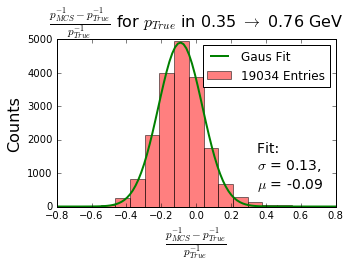

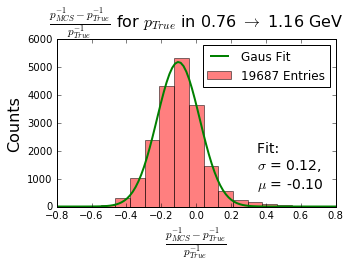

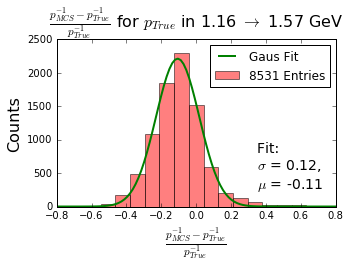

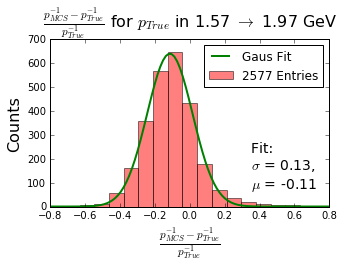

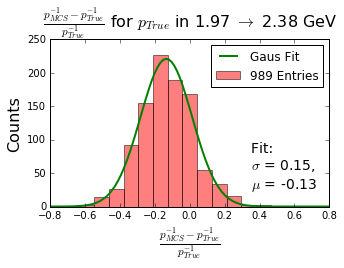

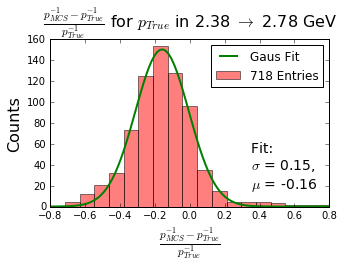

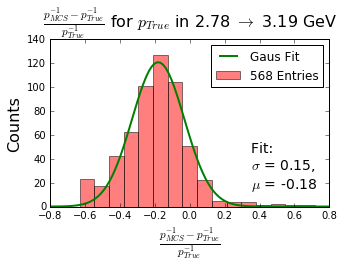

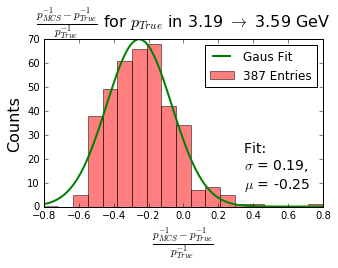

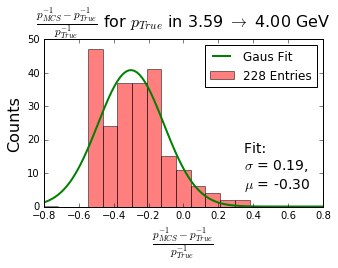

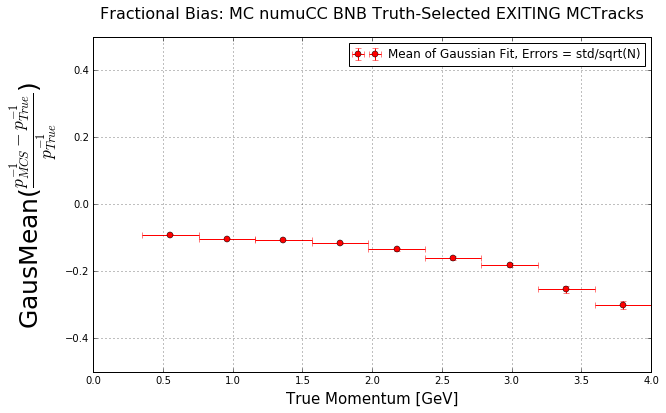

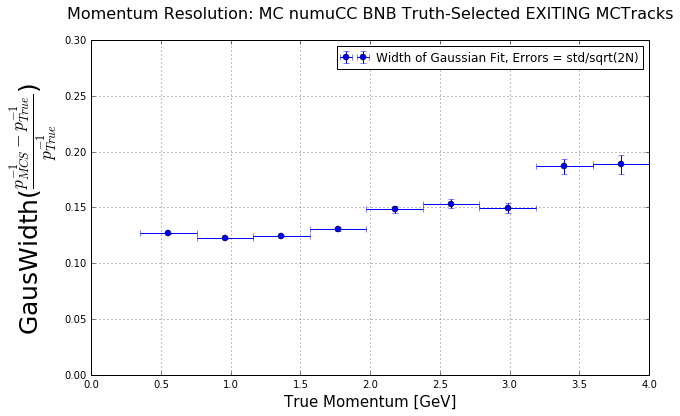

In [19]:
# Fractional bias plot for MCS vs true momentum for EXITING MCTRACK SECTION
if anatype == 'MCBNBMCTrackExiting':
    fractional_bias_resolution_plot(xvar='true_momentum_inverse',yvar='full_MCS_momentum_inverse',xbins=np.linspace(0.35,4,10),
                       plot_bin_distributions = True,
                       slicevar = 'true_momentum',
                       slicetitlebase = 'MCS_true_exiting_resolution_%s'%anatype,
                       slicebins = np.linspace(-0.8,0.8,20),
                       biasplotname = 'MCS_true_exiting_bias_%s.png'%anatype,
                       resplotname = 'MCS_true_exiting_resolution_%s.png'%anatype,
                       biasmainfig_ylims = (-.5,.5),
                       resmainfig_ylims = (0,.3),
                       usegausfit = True)


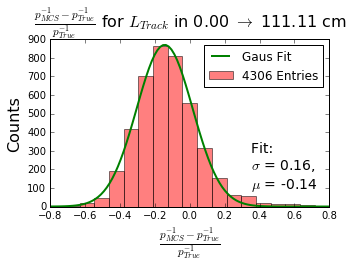

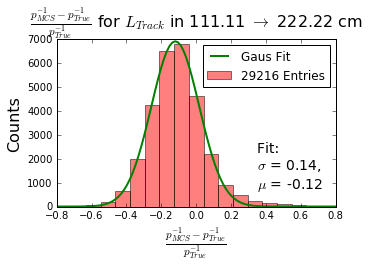

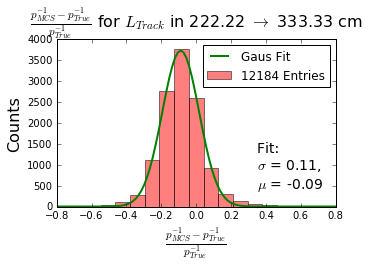

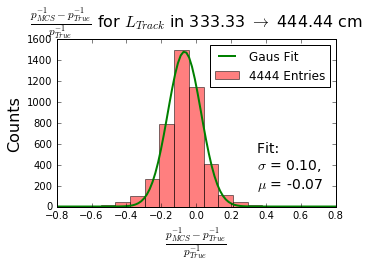

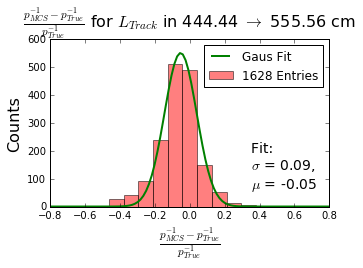

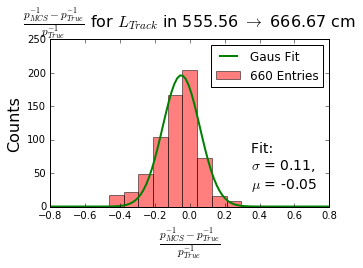

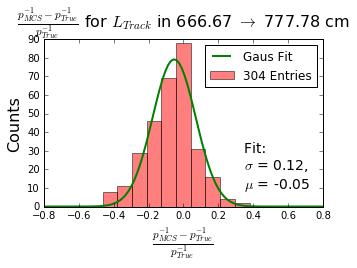

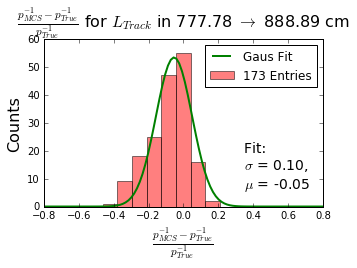

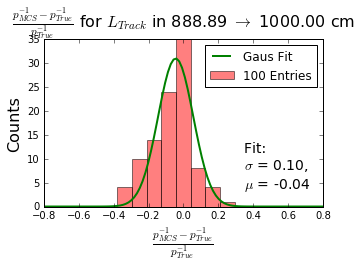

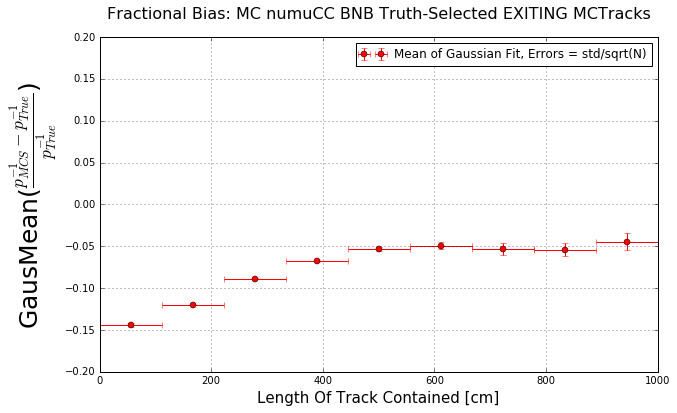

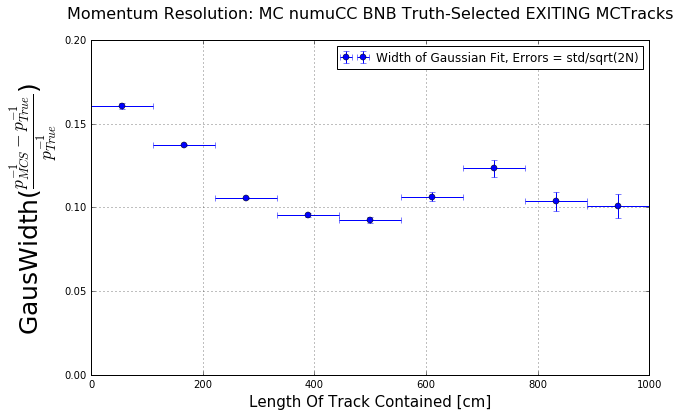

In [20]:
# Fractional bias plot for MCS vs range momentum for EXITING MCTRACK SECTION
# NOTE THAT RANGE MOMENTUM REALLY MEANS "LENGTH OF TRACK CONTAINED" HERE!!
if anatype == 'MCBNBMCTrackExiting':
    fractional_bias_resolution_plot(xvar='true_momentum_inverse',yvar='full_MCS_momentum_inverse',xbins=np.linspace(0,1000,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_length',
                       slicetitlebase = 'MCS_range_exiting_resolution_%s'%anatype,
                       slicebins = np.linspace(-0.8,0.8,20),
                       biasplotname = 'MCS_range_exiting_bias_%s.png'%anatype,
                       resplotname = 'MCS_range_exiting_resolution_%s.png'%anatype,
                       biasmainfig_ylims = (-0.2,0.2),
                       resmainfig_ylims = (0,0.2),
                       usegausfit = True)


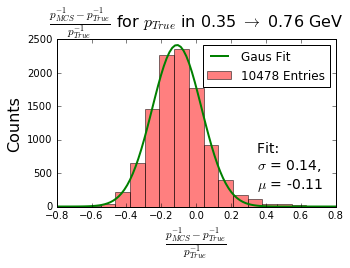

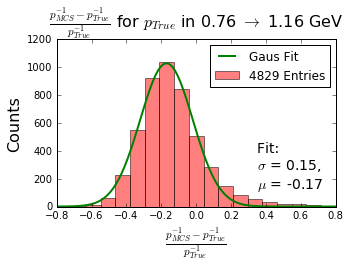

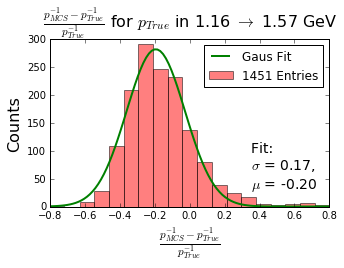

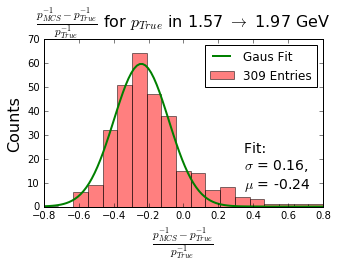

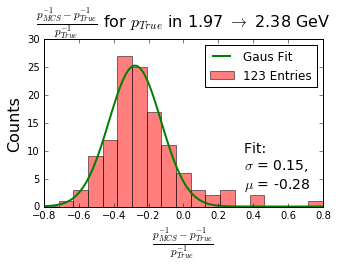

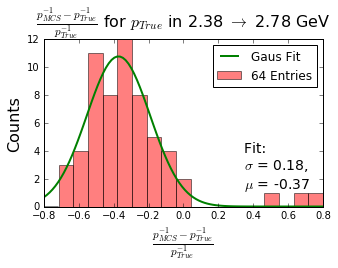

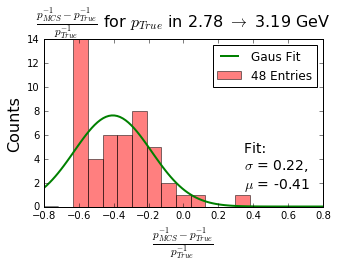

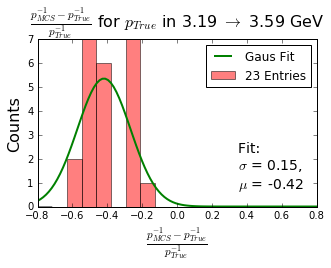

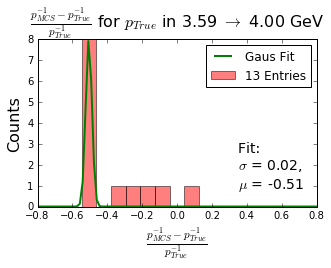

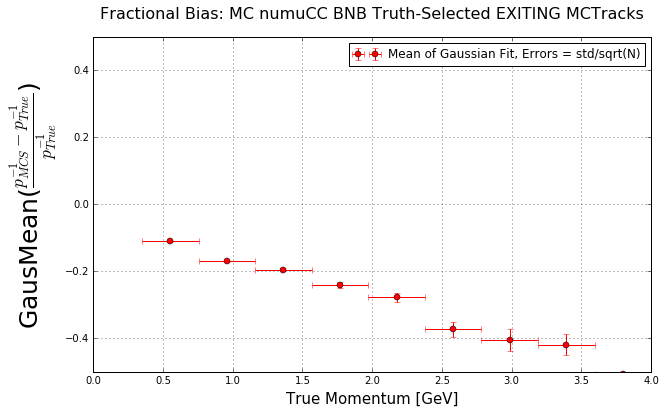

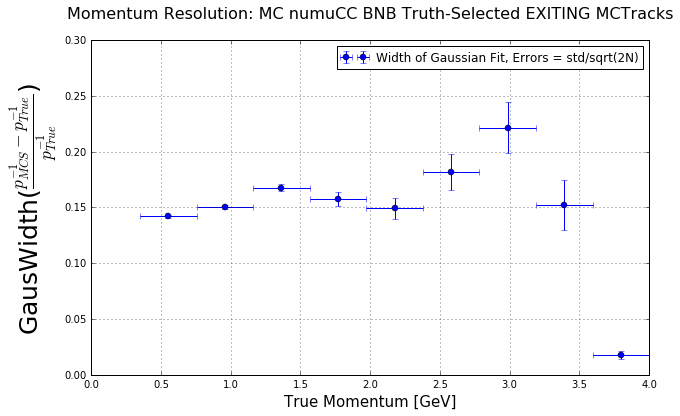

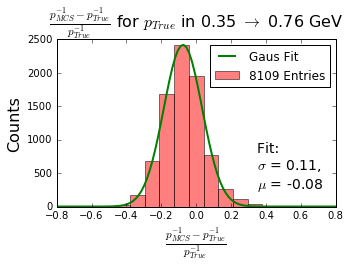

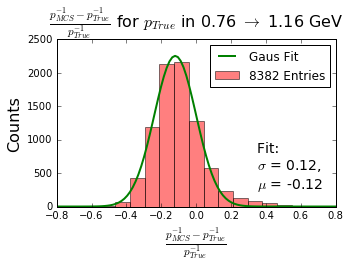

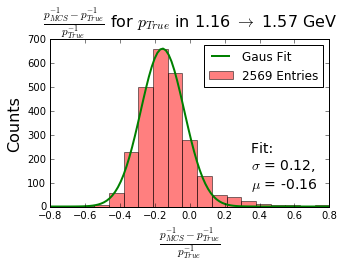

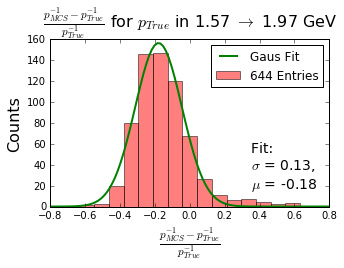

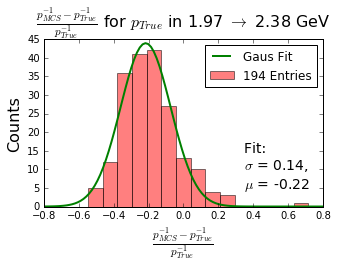

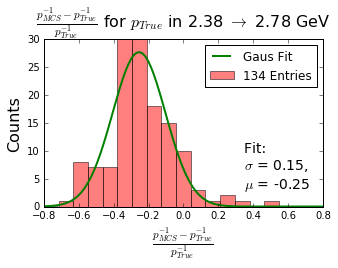

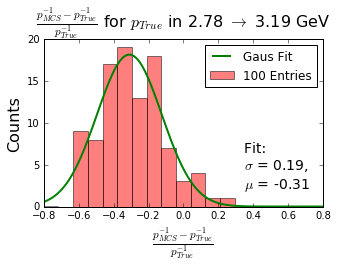

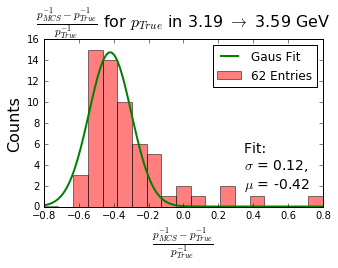

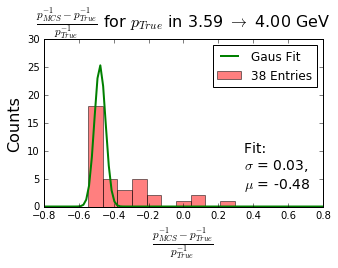

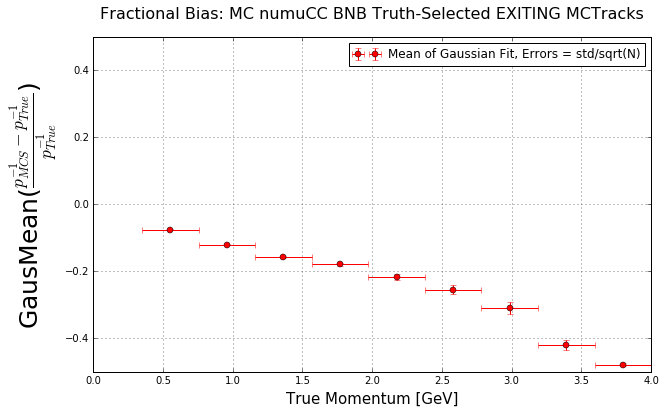

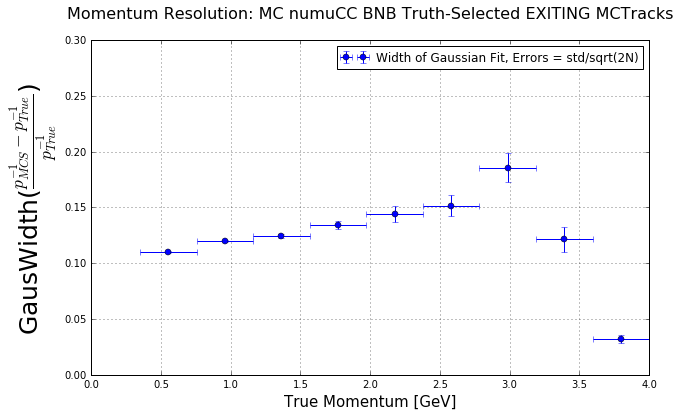

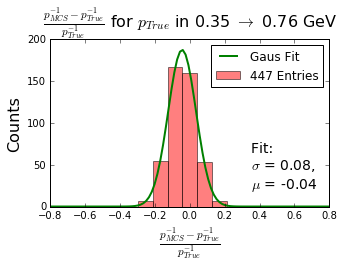

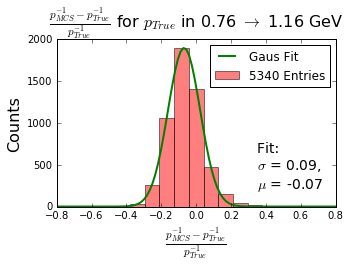

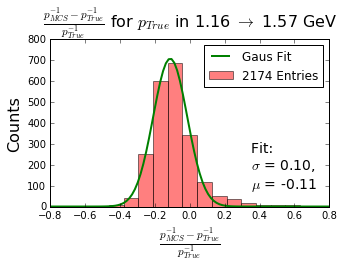

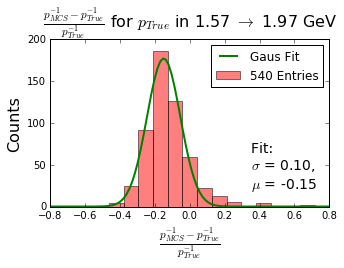

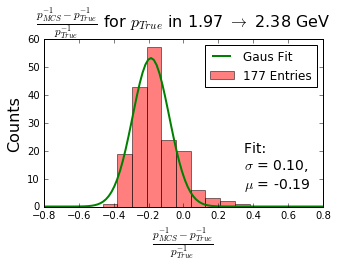

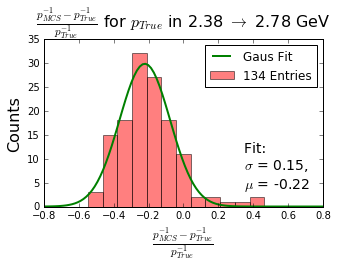

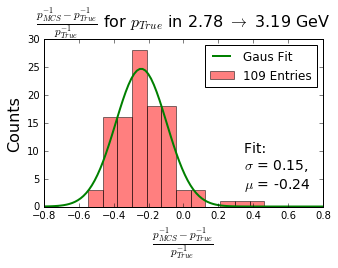

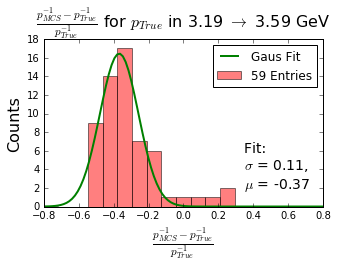

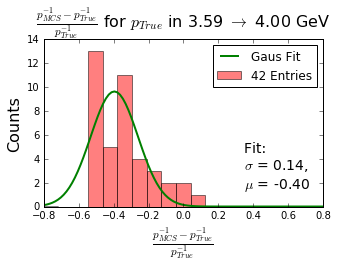

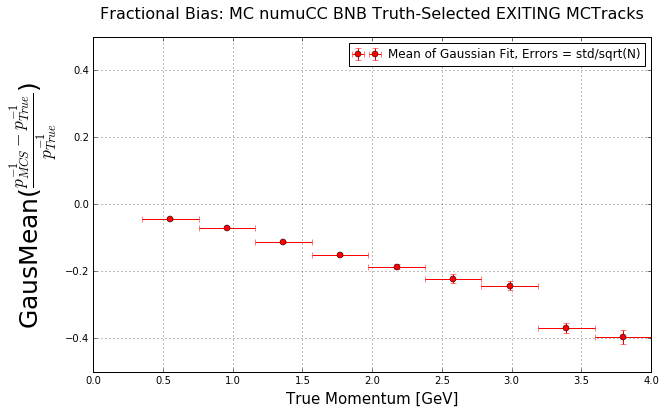

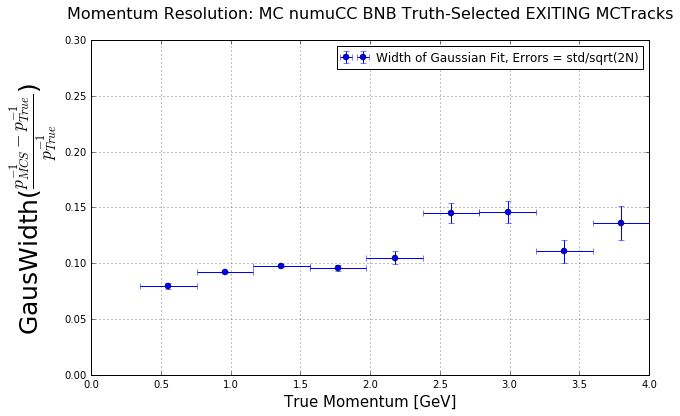

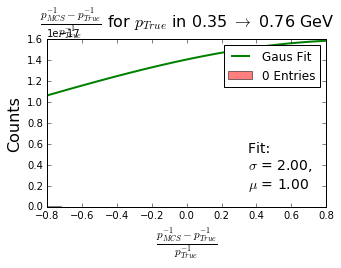

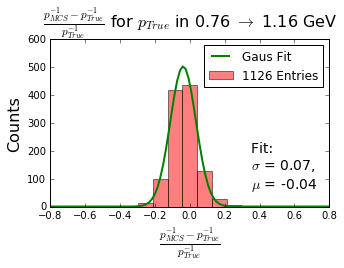

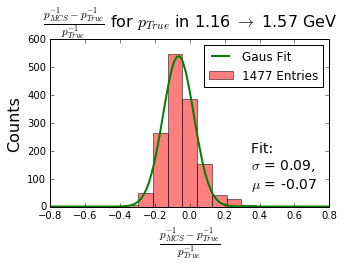

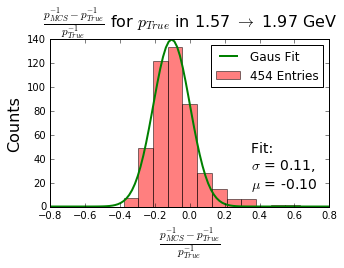

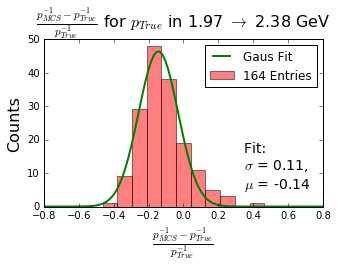

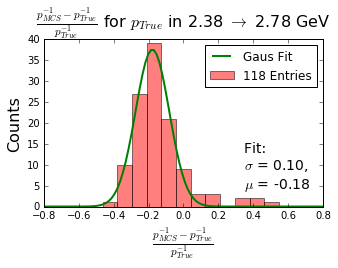

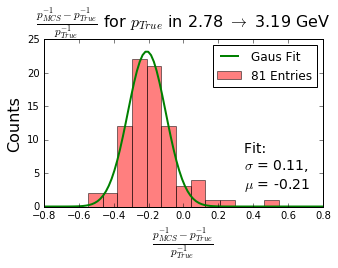

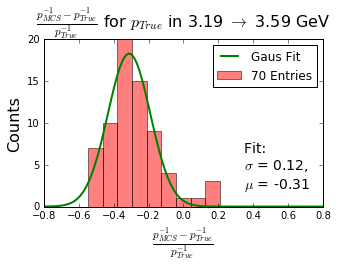

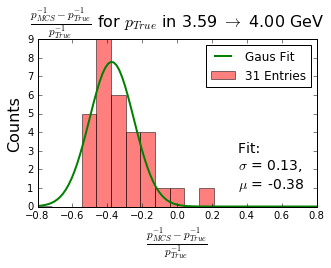

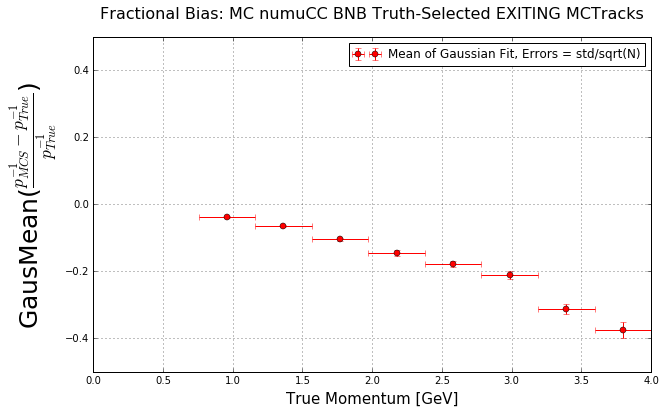

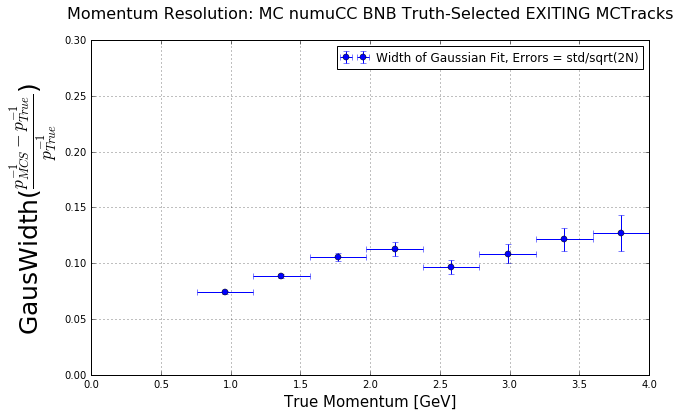

In [22]:
# Fractional bias plot for MCS vs true momentum for EXITING MCTRACK SECTION
# This is broken up for different bins of length!
if anatype == 'MCBNBMCTrackExiting':
    
    extraqueries = ['full_length < 150.',
                   'full_length > 150. and full_length < 250.',
                   'full_length > 250. and full_length < 350.',
                   'full_length > 350. and full_length < 450.']
    
    for extraquery in extraqueries:
        fractional_bias_resolution_plot(xvar='true_momentum_inverse',yvar='full_MCS_momentum_inverse',xbins=np.linspace(0.35,4,10),
                           plot_bin_distributions = True,
                           slicevar = 'true_momentum',
                           slicetitlebase = 'MCS_true_exiting_resolution_%s'%anatype,
                           slicebins = np.linspace(-0.8,0.8,20),
                           biasplotname = 'MCS_true_exiting_bias_%s.png'%anatype,
                           resplotname = 'MCS_true_exiting_resolution_%s.png'%anatype,
                           biasmainfig_ylims = (-.5,.5),
                           resmainfig_ylims = (0,.3),
                           extraquery=extraquery,
                           usegausfit = True)


In [ ]:
# Nominal fractional bias plot for all samples
# For MCBNBSelectedRecoTrack only make plot for the true muons
myextraquery = None
if anatype == 'MCBNBSelectedRecoTrack':
    myextraquery = 'MCT_PDG == 13 or MCT_PDG == -13'
# For real data events, only make plot for those events handscanned as "good"
if anatype == 'DataBNBSelectedRecoTrack':
    myextraquery = 'not maybe_bad'
    
# Trying inverse momentum
fractional_bias_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       extraquery = myextraquery,
                       slicetitlebase = 'MCS_range_resolution_%s'%anatype,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_%s.png'%anatype,
                       resplotname = 'MCS_range_resolution_%s.png'%anatype,
                       biasmainfig_ylims = (-.10,.10),
                       resmainfig_ylims = (0,.15),
                        usegausfit = True)

In [ ]:
##Here I fit the resolution to a realistic resolution equation
#def res_eqtn(E,a,b,c):
#    return np.sqrt(np.square(a/np.sqrt(E)) + np.square(b/E) + np.square(c))
#
##def res_eqtn(x,a):
##    return a/np.sqrt(x)
#
##def res_eqtn(E,a,b,c):
##    return np.sqrt(np.square(a/np.sqrt(1./E)) + np.square(b/(1./E)) + np.square(c))
#
#
##reco-true/true
#def resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
#                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
#                         extraquery = None,
#                        plotname = None, mainfig_ylims = None):
#    
#    #This includes a fit to a realistic resolution equation
#    
#    binning = xbins
#    binwidth = float(binning[1]-binning[0])
#    bincenters = binning + (binwidth/2)
#    myreses, mystds, myerrs = [], [], []
#    myN = []
#    for x in xrange(len(binning)-1):
#        
#        binmin = binning[x]
#        binmax = binning[x+1]
#        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
#        myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
#        if anatype == 'DataBNBSelectedRecoTrack':
#            myquery += ' and not maybe_bad'
#        if extraquery is not None:
#            myquery += ' and %s' % extraquery
#            
#        mydf = df.query(myquery)
#        true = mydf[xvar].values
#        reco = mydf[yvar].values
#        mymean = ((reco-true)/true).mean()
#        mystd = ((reco-true)/true).std()
#        #Error of standard deviation is sigma/sqrt(2N)
#        myerr = mystd / np.sqrt( 2 * float(len(true)) )
#        myN.append(len(true))
#        myreses.append( mymean )
#        mystds.append( mystd )
#        myerrs.append( myerr )
#            
#    plt.figure(figsize=(10,6))
#    plt.errorbar(bincenters[:-1],mystds,yerr=myerrs,fmt='o--',label='Std of Distribution, Errors = std/sqrt(2N)')
#    plt.ylabel('std($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
#    plt.xlabel('%s'%titles[xvar],fontsize=15)
#    plt.grid(True)
#    t = plt.title('Momentum Resolution: %s' % titles[anatype],fontsize=16)
#    #move the title up a bit
#    t.set_y(1.04) 
#                    
#    if mainfig_ylims is not None:
#        blah = plt.ylim(mainfig_ylims)
#    if write_figures and plotname is not None:
#        print " \n\n Writing the main figure!! %s \n\n" % (figdir+plotname)
#        plt.tight_layout()
#        plt.savefig(figdir + plotname)
#    
##     if draw_fit:
##         popt, pcov = curve_fit(res_eqtn, bincenters[:-1], mystds, sigma=myerrs)
#        
##         fitx = np.linspace(0.35,1,100)
##         fity = res_eqtn(fitx,popt[0],popt[1],popt[2])
##         labelstring = 'Resolution Fit: '
##         labelstring += '$[\\frac{a}{\sqrt{E}} \circ \\frac{b}{E} \circ c]$'
##         plt.plot(fitx,fity,'r-',label=labelstring)
#   
##         plt.legend(loc='best')
#    
##         return popt, pcov
##     else:
##         plt.legend(loc='best')
##         return (-1, -1)

In [ ]:
## Fractional resolution plot for True vs Range energy for single MCTrack section only
#if anatype == 'SingleMuonMCTrack':
#    resolution_plot(xvar='true_E',yvar='full_range_energy',xbins=np.linspace(0.35,2,10),
#                       slicevar = 'full_range_energy',
#                       plotname = 'true_range_resolution_%s.png'%anatype,
#                       mainfig_ylims = (0,.05))
#   
## Nominal fractional bias plot for all samples
## For MCBNBSelectedRecoTrack only plot for the true muons
#myextraquery = None
#if anatype == 'MCBNBSelectedRecoTrack':
#    myextraquery = 'MCT_PDG == 13 or MCT_PDG == -13'
## For real data events, only make plot for those events handscanned as "good"
#if anatype == 'DataBNBSelectedRecoTrack':
#    myextraquery = 'not maybe_bad'
#    w
#resolution_plot(xvar='full_range_momentum',yvar='full_MCS_momentum',xbins=np.linspace(0.35,2,10),
#                       slicevar = 'full_range_momentum',
#                       extraquery = myextraquery,
#                       plotname = 'MCS_range_resolution_%s.png'%anatype,
#                       mainfig_ylims = (0,.25))
#